In [12]:
import base64, json, os
from io import BytesIO
from random import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

In [3]:
gold_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255),]

In [4]:
def get_font_info(img_size):
    font = cv2.FONT_HERSHEY_SIMPLEX  # default font
    ref = (img_size[0] + img_size[1]) / 2
    font_scale = ref / 1000
    font_thickness = int(max(ref / 400, 1))
    return font, font_scale, font_thickness


def get_random_colors(labels):
    label_set = set(labels)
    label_counts = [(l, labels.count(l)) for l in label_set]
    label_counts = sorted(label_counts, key=lambda x: -x[1])
    label2color = {}
    # the most frequeny classes will get the gold colors
    gold_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]
    for i, lab in enumerate(label_counts):
        if i < len(gold_colors):
            label2color[lab[0]] = gold_colors[i]
        else:
            label2color[lab[0]] = (random() * 255, random() * 255, 
                                   random() * 255)
    return label2color


def put_text(im, text, bottomleft=(0,100), color=(255,255,255), 
        font_scale=0.5, font_thickness=1):
    # function borrowed from quickdetection
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(im, text, bottomleft, font, font_scale, color,
            thickness=font_thickness)
    return cv2.getTextSize(text, font, font_scale, font_thickness)[0]


def draw_bb(im, all_rect, all_label, probs=None, color=None, 
        draw_label=True):
    '''
    function borrowed from quickdetection.
    all_rect: in xyxy mode
    all_label: list of class names
    probs: list of confidence scores, will show if given
    '''
    font, font_scale, font_thickness = get_font_info(im.shape[:2])

    dist_label = set(all_label)
    if color is None:
        color = {}
        for l in dist_label:
            if l in color:
                continue
            if len(gold_colors) > 0:
                color[l] = gold_colors.pop()
    for i, l in enumerate(dist_label):
        if l in color:
            continue
        color[l] = (random() * 255., random() * 255, random() * 255)

    if type(all_rect) is list:
        assert len(all_rect) == len(all_label) 
    elif type(all_rect) is np.ndarray:
        assert all_rect.shape[0] == len(all_label)
        assert all_rect.shape[1] == 4
    else:
        assert False
    
    for i in range(len(all_label)):
        rect = all_rect[i]
        label = all_label[i]
        cv2.rectangle(im, (int(rect[0]), int(rect[1])), 
                (int(rect[2]), int(rect[3])), color[label], 
                thickness=font_thickness)
        if probs is not None:
            if draw_label:
                label_in_image = '{}-{:.2f}'.format(label, probs[i])
            else:
                label_in_image = '{:.2f}'.format(probs[i])
        else:
            if draw_label:
                label_in_image = '{}'.format(label)

        def gen_candidate():
            # above of top left
            yield int(rect[0]) + 2, int(rect[1]) - 4
            # below of bottom left
            yield int(rect[0]) + 2, int(rect[3]) + text_height + 2
        if draw_label or probs is not None:
            (_, text_height), _ = cv2.getTextSize(label_in_image, font,
                                                  font_scale, font_thickness)
            for text_left, text_bottom in gen_candidate():
                if 0 <= text_left < im.shape[1] - 12 and 12 < text_bottom  < im.shape[0]:
                    put_text(im, label_in_image, (text_left, text_bottom), color[label],
                            font_scale, font_thickness)
                    break


def get_text_image(img_size, text, bg_color=(0,0,0), text_color=(255,255,255)):
    # generate a blank image with centered text
    font, font_scale, font_thickness = get_font_info(img_size)
    img = np.ones((img_size[1], img_size[0], 3), np.uint8)
    img[:,:,0] = img[:,:,0] * bg_color[0]
    img[:,:,1] = img[:,:,1] * bg_color[1]
    img[:,:,2] = img[:,:,2] * bg_color[2]
    textsize = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    textX = int((img.shape[1] - textsize[0]) / 2)
    textY = int((img.shape[0] + textsize[1]) / 2)
    cv2.putText(img, text, (textX, textY), font, font_scale, text_color, font_thickness)
    return img


def load_colormap_file(colormap_file):
    if not colormap_file:
        return 
    label2color = {}
    with open(colormap_file, 'r') as f:
        for line in f:
            item = line.strip().split('\t')
            label2color[item[0]] = [float(_) for _ in item[1].split(' ')]
    return label2color

def draw_rel(im, all_rel_subj_center, all_rel_obj_center, all_rel_label, probs=None, color=None, 
        draw_label=True):
    font, font_scale, font_thickness = get_font_info(im.shape[:2])

    dist_label = set(all_rel_label)
    if color is None:
        color = {}
        for l in dist_label:
            if l in color:
                continue
            if len(gold_colors) > 0:
                color[l] = gold_colors.pop()
    for i, l in enumerate(dist_label):
        if l in color:
            continue
        color[l] = (random() * 255., random() * 255, random() * 255)
    
    for i in range(len(all_rel_label)):
        subj_center = all_rel_subj_center[i]
        obj_center = all_rel_obj_center[i]
        label = all_rel_label[i]
        cv2.line(im, (int(subj_center[0]), int(subj_center[1])), 
                (int(obj_center[0]), int(obj_center[1])), color[label], 
                thickness=font_thickness)
        if probs is not None:
            if draw_label:
                label_in_image = '{}-{:.2f}'.format(label, probs[i])
            else:
                label_in_image = '{:.2f}'.format(probs[i])
        else:
            if draw_label:
                label_in_image = '{}'.format(label)

        def gen_candidate():
            # above of top left
            rel_center = [(subj_center[0]+obj_center[0])/2, (subj_center[1]+obj_center[1])/2]
            yield int(rel_center[0]) + 2, int(rel_center[1]) - 4
            # below of bottom left
            yield int(rel_center[0]) + 2, int(rel_center[1]) + text_height + 2
        if draw_label or probs is not None:
            (_, text_height), _ = cv2.getTextSize(label_in_image, font,
                                                  font_scale, font_thickness)
            for text_left, text_bottom in gen_candidate():
                if 0 <= text_left < im.shape[1] - 12 and 12 < text_bottom  < im.shape[0]:
                    put_text(im, label_in_image, (text_left, text_bottom), color[label],
                            font_scale, font_thickness)
                    break

In [5]:
with open("/home/yingshac/CYS/WebQnA/RegionFeature/genome_1600_400_20_obj_vocab.txt", "r") as fp:
    classes = [l.strip() for l in fp.readlines()]
class_map = dict(zip(range(len(classes)), classes))

In [16]:
# positive images for img-based queries
with open("/data/yingshac/MMMHQA/detectron_output/gold.lineidx", "r") as fp, open("/data/yingshac/MMMHQA/base64/gold_img.lineidx", "r") as fp_img:
# negative images for img-based queries
#with open("/data/yingshac/MMMHQA/detectron_output/distractors.lineidx", "r") as fp, open("/data/yingshac/MMMHQA/base64/neg_img.lineidx", "r") as fp_img:
# negative images for txt-based queries
#with open("/data/yingshac/MMMHQA/detectron_output/x_distractors.lineidx", "r") as fp, open("/data/yingshac/MMMHQA/base64/x_neg_img.lineidx", "r") as fp_img:
    pred_lineidx = [int(i.strip()) for i in fp.readlines()]
    print(len(pred_lineidx))
    img_lineidx = [int(i.strip()) for i in fp_img.readlines()]
    print(len(img_lineidx))

22265
22265


00000203 {"image_id": 203}
[532, 800] (532, 800, 3)
<class 'int'>
(100, 2048)
(100, 1601)


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


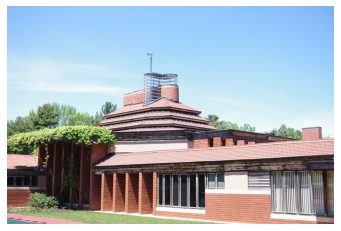

In [19]:
k = 203
# positive images for img-based queries, image_ids range from 0 to 22265
with open("/data/yingshac/MMMHQA/detectron_output/gold.tsv", "r") as fp, open("/data/yingshac/MMMHQA/base64/gold_img.tsv", "r") as fp_img:
# negative images for img-based queries, image_ids range from 10000000 to 10340193
#with open("/data/yingshac/MMMHQA/detectron_output/distractors.tsv", "r") as fp, open("/data/yingshac/MMMHQA/base64/neg_img.tsv", "r") as fp_img:
# negative images for txt-based queries, image_ids range from 20000000 to 20240699
#with open("/data/yingshac/MMMHQA/detectron_output/x_distractors.tsv", "r") as fp, open("/data/yingshac/MMMHQA/base64/x_neg_img.tsv", "r") as fp_img:
    fp.seek(pred_lineidx[k])
    row = fp.readline().strip().split('\t')
    fp_img.seek(img_lineidx[k])
    img_idx, imgid, img_base64 = fp_img.readline().strip().split('\t')
    print(row[1], imgid) # image_id in feature file and image_id in img file should agree
    im = cv2.imdecode(np.fromstring(base64.b64decode(img_base64), dtype=np.uint8), cv2.IMREAD_COLOR)
    pred = json.loads(row[-1])
    print(pred['image_size'], im.shape) # height and width should agree
    print(type(pred['num_instances']))
    labels = [class_map[i] for i in np.frombuffer(base64.b64decode(pred['pred_classes']), np.int64).tolist()] 
    scores = np.frombuffer(base64.b64decode(pred['scores']), np.float32).tolist() # confidence scores
    rects = np.frombuffer(base64.b64decode(pred['pred_boxes']), np.float32).reshape((100,4)).tolist()
    print(np.frombuffer(base64.b64decode(pred['fc1_features']), np.float32).reshape((100,2048)).shape)
    print(np.frombuffer(base64.b64decode(pred['cls_features']), np.float32).reshape((100,1601)).shape) # classification likelihoods
plt.axis('off')
plt.imshow(im[:,:,::-1])

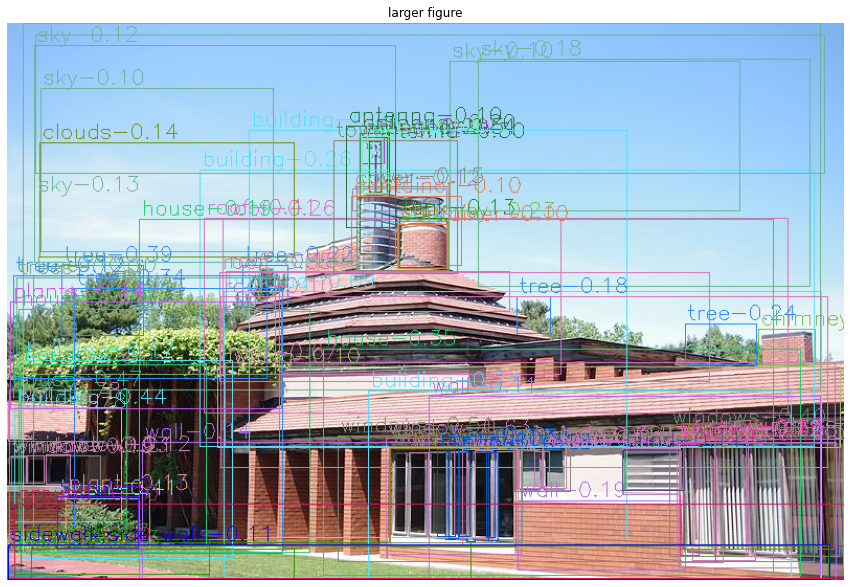

In [20]:
draw_bb(im, rects, labels, scores)
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
ax.imshow(im[:,:,::-1])
ax.set_title('larger figure')
plt.axis('off')
plt.show()